<a href="https://colab.research.google.com/github/BearKS/Robotic-weed-control-system/blob/feature%2Fextraction/weed_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
!pip install opencv-python-headless
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [246]:
# Import the necessary libraries
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [247]:
# Connect Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [248]:
# Load path of segmentation mask image
image_path = "/content/gdrive/MyDrive/Project/sweet_basil/mask/0_output.png"
print(image_path)
# # Load Pr mask from segmentation
# image_path = pr_mask


/content/gdrive/MyDrive/Project/sweet_basil/mask/0_output.png


In [249]:
def denoise_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # img = cv2.imread('plant_image.jpg', cv2.IMREAD_GRAYSCALE)
    # Check if image was loaded successfully
    if img is None:
        print('Error: Failed to load image at path:', image_path)
        return None

    else:
        # Define structuring elements
        kernel_rect = np.ones((5, 5), np.uint8)
        kernel_circ = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
        
        # Apply morphology operations with different kernels
        eroded_rect = cv2.erode(img, kernel_rect, iterations=1)
        dilated_rect = cv2.dilate(eroded_rect, kernel_rect, iterations=1)
    
        eroded_circ = cv2.erode(img, kernel_circ, iterations=1)
        dilated_circ = cv2.dilate(eroded_circ, kernel_circ, iterations=1)
    
        eroded_cross = cv2.erode(img, kernel_cross, iterations=1)
        dilated_cross = cv2.dilate(eroded_cross, kernel_cross, iterations=1)

        # Combine the eroded images
        eroded = cv2.bitwise_or(eroded_rect, eroded_circ)
        eroded = cv2.bitwise_or(eroded, eroded_cross)

        # Combine the denoised images
        denoised = cv2.bitwise_or(dilated_rect, dilated_circ)
        denoised = cv2.bitwise_or(denoised, dilated_cross)
        denoised = cv2.cvtColor(denoised_img, 0)

        return img,eroded,denoised

In [250]:
input_img,eroded_img,denoised_img = denoise_image(image_path)

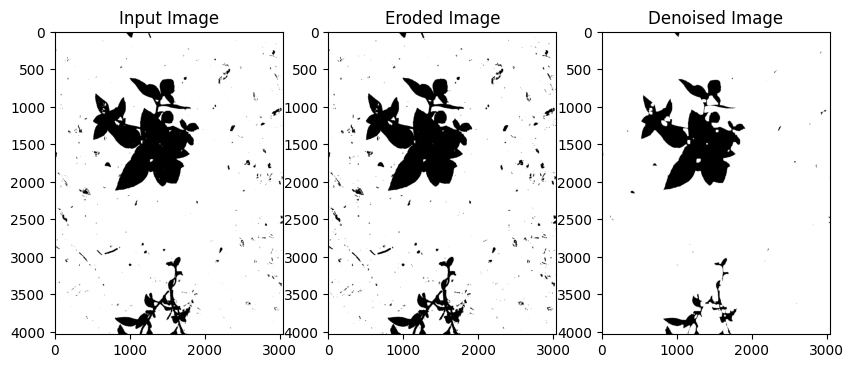

In [251]:
# Check if the denoised image was returned successfully
if denoised_img is not None:
    # Visualize the input and output images
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(input_img, cmap='gray')
    ax[0].set_title('Input Image')
    ax[1].imshow(eroded_img, cmap='gray')
    ax[1].set_title('Eroded Image')
    ax[2].imshow(denoised_img, cmap='gray')
    ax[2].set_title('Denoised Image')
    plt.show()

(4032, 3040, 4)
<class 'numpy.ndarray'>


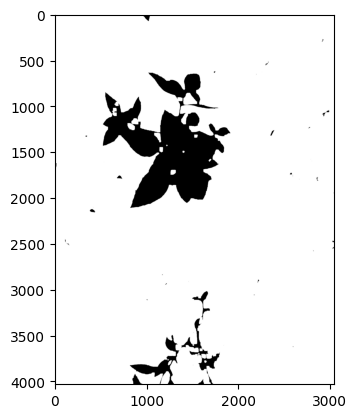

In [252]:
#check
print(denoised_img.shape)
print(type(denoised_img))
plt.imshow(denoised_img)

20516.4


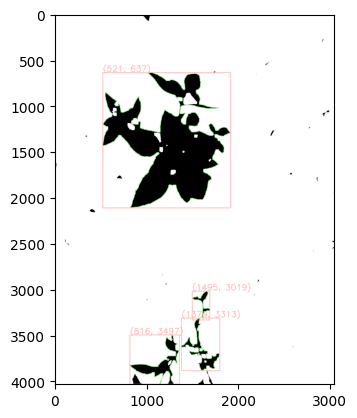

In [292]:
from google.colab.patches import cv2_imshow
# Check if image was loaded successfully
if denoised_img is None:
    print('Error: Failed to load image at path:', image_path)
else:
    gray_img = denoised_img
    gray_img = gray_img.astype(np.uint8)

    # Apply Canny edge detection
    edges = cv2.Canny(gray_img, 100, 200)

    # Perform morphological operations (dilate and erode) to close gaps in the edges
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    # Find the contours in the processed image
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Define the minimum area threshold
    max_area = 0

    # Define list for store position
    all_box_position = []

    # largest_bbox_position = (0, 0, 0, 0)
    for contour in contours:
      _, _, w, h = cv2.boundingRect(contour)
      area = w * h
      max_area = max(max_area, area)
      # largest_bbox_position = (x, y, w, h)
      

    # Set the minimum area threshold as the largest bounding box area
    min_area = max_area/100
    print(min_area)

    # Draw the contours on the original image
    result = denoised_img.copy()
    for contour in contours:
      # Calculate the bounding box
      x, y, w, h = cv2.boundingRect(contour)
      area = w * h
      # Only draw the contour and bounding box if the area is larger than the minimum area threshold
      if area >= min_area:
        # Draw the contour
        cv2.drawContours(result, [contour], 0, (0, 255, 0), 2)

        # Draw the bounding box
        cv2.rectangle(result, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Add box position to the list
        all_box_position.append((x, y, w, h))

        # Print position
        position_text = f"({x}, {y})"
        cv2.putText(result, position_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 2)

    # Display the result
    plt.imshow(result)

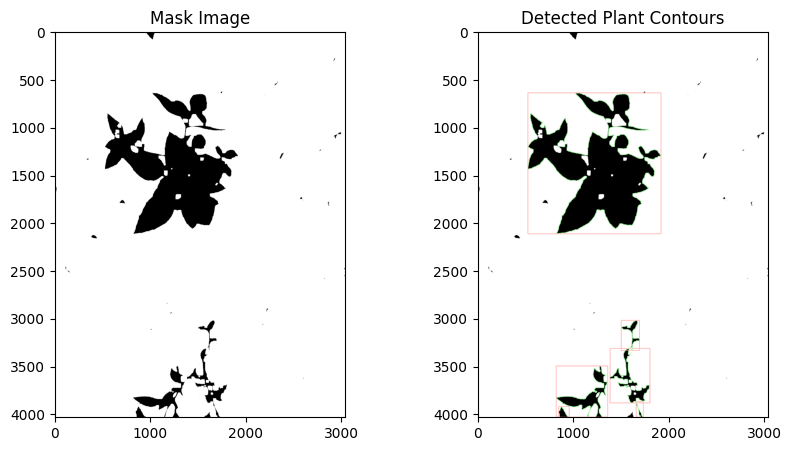

In [277]:
# Visualize input and output images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(denoised_img, cmap='gray')
ax[0].set_title('Mask Image')
ax[1].imshow(result, cmap='gray')
ax[1].set_title('Detected Plant Contours')
plt.show()

In [287]:
# Return the positions of all bounding boxes
print("Bounding box positions (x, y, width, height):")
for position in all_box_position:
    print(position)

Bounding box positions (x, y, width, height):
(816, 3497, 539, 535)
(1379, 3313, 417, 571)
(1495, 3019, 192, 315)
(521, 637, 1390, 1476)
